In [42]:
#importing library
import numpy as np
import pandas as pd
import plotly.express as px
import re
#natural language tool kit
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import tensorflow as tf

In [43]:
#loading the dataset
df=pd.read_csv('../input/ramen-ratings/ramen-ratings.csv')
df

,Review #,Brand,Variety,Style,Country,Stars,Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN
...,...,...,...,...,...,...,...
2575,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.5,NaN
2576,4,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1,NaN
2577,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2,NaN
2578,2,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2,NaN


In [44]:
#getting information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review #  2580 non-null   int64 
 1   Brand     2580 non-null   object
 2   Variety   2580 non-null   object
 3   Style     2578 non-null   object
 4   Country   2580 non-null   object
 5   Stars     2580 non-null   object
 6   Top Ten   41 non-null     object
dtypes: int64(1), object(6)
memory usage: 141.2+ KB


# Preprocessing

In [45]:
#getting number of null values in each column
df.isna().sum()

Review #       0
Brand          0
Variety        0
Style          2
Country        0
Stars          0
Top Ten     2539
dtype: int64

In [46]:
#getting the unique values in top ten column
df['Top Ten'].unique()

array([nan, '2016 #10', '2016 #1', '2016 #8', '2016 #5', '2016 #9',
       '2016 #7', '2015 #10', '2015 #7', '2015 #4', '2015 #9', '2015 #6',
       '2015 #1', '2013 #10', '2015 #8', '2014 #7', '2014 #4', '2014 #9',
       '2014 #10', '2014 #8', '2014 #5', '2014 #6', '2014 #1', '2013 #1',
       '2013 #2', '2013 #4', '\n', '2013 #9', '2013 #3', '2012 #10',
       '2012 #7', '2012 #5', '2012 #3', '2012 #6', '2012 #9', '2012 #1',
       '2012 #2', '2013 #6', '2012 #4'], dtype=object)

In [47]:
#replacing \n with np.Nan
df['Top Ten']=df['Top Ten'].replace('\n',np.nan)

In [48]:
#applying lamda function to top ten to convert 
df['is Top Ten']=df['Top Ten'].apply(lambda x:0 if str(x)=='nan' else 1)

In [49]:
#dropping the top ten column
df=df.drop('Top Ten',axis=1)

In [50]:
#dropping row which has na values and then resetting the index
df=df.dropna(axis=0).reset_index(drop=True)

In [51]:
df

,Review #,Brand,Variety,Style,Country,Stars,is Top Ten
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,0
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,0
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,0
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,0
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,0
...,...,...,...,...,...,...,...
2573,5,Vifon,"Hu Tiu Nam Vang [""Phnom Penh"" style] Asian Sty...",Bowl,Vietnam,3.5,0
2574,4,Wai Wai,Oriental Style Instant Noodles,Pack,Thailand,1,0
2575,3,Wai Wai,Tom Yum Shrimp,Pack,Thailand,2,0
2576,2,Wai Wai,Tom Yum Chili Flavor,Pack,Thailand,2,0


In [52]:
#checking for Unrated values in Stars column
df.query("Stars=='Unrated'")

,Review #,Brand,Variety,Style,Country,Stars,is Top Ten
32,2548,Ottogi,Plain Instant Noodle No Soup Included,Pack,South Korea,Unrated,0
122,2458,Samyang Foods,Sari Ramen,Pack,South Korea,Unrated,0
993,1587,Mi E-Zee,Plain Noodles,Pack,Malaysia,Unrated,0


In [53]:
#replacing Unrated value with Nan
df['Stars']=df['Stars'].replace('Unrated',np.NaN)
#converting string to integer
df['Stars']=df['Stars'].astype(np.float)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


In [54]:
#filling na with mean of the column in stars
df['Stars']=df['Stars'].fillna(df['Stars'].mean())

In [55]:
df['Stars'].isna().sum()

0

# Engineering Variety Features

In [56]:
#all rows only from Variety column
ramen_names=df.loc[:,'Variety']

In [57]:
ramen_names

0                               T's Restaurant Tantanmen 
1       Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...
2                           Cup Noodles Chicken Vegetable
3                           GGE Ramen Snack Tomato Flavor
4                                         Singapore Curry
                              ...                        
2573    Hu Tiu Nam Vang ["Phnom Penh" style] Asian Sty...
2574                       Oriental Style Instant Noodles
2575                                       Tom Yum Shrimp
2576                                 Tom Yum Chili Flavor
2577                                           Miso Ramen
Name: Variety, Length: 2578, dtype: object

In [58]:
ps=PorterStemmer()
def process_name(name):
    new_name=name.lower()
    new_name=re.sub(r'[^a-z0-9\s]','', new_name)
    new_name=re.sub(r'[0-9]+','number',new_name)
    new_name=new_name.split(' ')
    new_name=list(map(lambda x: ps.stem(x),new_name))
    new_name=list(map(lambda x: x.strip(),new_name))
    for i in range(len(new_name)):
        if new_name[i]=='flavour':
            new_name[i]='flavor'
    if '' in new_name:
        new_name.remove('')
    return new_name
    
                    

In [59]:
ramen_names=ramen_names.apply(process_name)

In [60]:
ramen_names

0                                [ts, restaur, tantanmen]
1       [noodl, spici, hot, sesam, spici, hot, sesam, ...
2                            [cup, noodl, chicken, veget]
3                     [gge, ramen, snack, tomato, flavor]
4                                       [singapor, curri]
                              ...                        
2573    [hu, tiu, nam, vang, phnom, penh, style, asian...
2574                      [orient, style, instant, noodl]
2575                                   [tom, yum, shrimp]
2576                            [tom, yum, chili, flavor]
2577                                        [miso, ramen]
Name: Variety, Length: 2578, dtype: object

In [61]:
#checking the maximum length of a single ramen name
max_seq_length=max(ramen_names.apply(lambda x:len(x)))

In [62]:
#checking for unique words in our list of ramen names
vocabulary=set()
for name in ramen_names:
    for word in name:
        if word not in vocabulary:
            vocabulary.add(word)
vocab_length=len(vocabulary)

In [63]:
print('Vocab length',vocab_length)
print('Max sequence length',max_seq_length)

Vocab length 1371
Max sequence length 13


In [64]:
#assigning number to each word
tokenizer=Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(ramen_names)
word_index=tokenizer.word_index
#mapping word to index number in word_index
sequences=tokenizer.texts_to_sequences(ramen_names)
names_features=pad_sequences(sequences,maxlen=max_seq_length,padding='post')

In [65]:
names_features

array([[511, 402, 324, ...,   0,   0,   0],
       [  1,   6,  18, ...,   0,   0,   0],
       [  8,   1,   5, ...,   0,   0,   0],
       ...,
       [ 15,  23,  16, ...,   0,   0,   0],
       [ 15,  23,  69, ...,   0,   0,   0],
       [ 43,   4,   0, ...,   0,   0,   0]], dtype=int32)

In [66]:
#now droping variet from the dataset
df=df.drop('Variety',axis=1)

In [67]:
df

,Review #,Brand,Style,Country,Stars,is Top Ten
0,2580,New Touch,Cup,Japan,3.75,0
1,2579,Just Way,Pack,Taiwan,1.00,0
2,2578,Nissin,Cup,USA,2.25,0
3,2577,Wei Lih,Pack,Taiwan,2.75,0
4,2576,Ching's Secret,Pack,India,3.75,0
...,...,...,...,...,...,...
2573,5,Vifon,Bowl,Vietnam,3.50,0
2574,4,Wai Wai,Pack,Thailand,1.00,0
2575,3,Wai Wai,Pack,Thailand,2.00,0
2576,2,Wai Wai,Pack,Thailand,2.00,0


In [68]:
#creating one hot encode
def onehot_encode(df,column,prefixes):
    df=df.copy()
    for column,prefix in zip(column,prefixes):
        dummies=pd.get_dummies(df[column],prefix=prefix)
        df=pd.concat([df,dummies],axis=1)
        df=df.drop(column,axis=1)
    return df
        

In [69]:
df=onehot_encode(df,['Brand','Style','Country'],prefixes=['B','S','C'])

In [70]:
df

,Review #,Stars,is Top Ten,B_1 To 3 Noodles,B_7 Select,B_7 Select/Nissin,B_A-One,B_A-Sha Dry Noodle,B_A1,B_ABC,...,C_Sarawak,C_Singapore,C_South Korea,C_Sweden,C_Taiwan,C_Thailand,C_UK,C_USA,C_United States,C_Vietnam
0,2580,3.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2579,1.00,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2578,2.25,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2577,2.75,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,2576,3.75,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,5,3.50,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2574,4,1.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2575,3,2.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2576,2,2.00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [71]:
label=df.loc[:,'is Top Ten']
feature=df.drop('is Top Ten',axis=1)

In [72]:
#mean 0 and univariance
scaler=StandardScaler()
feature=pd.DataFrame(scaler.fit_transform(feature),columns=feature.columns)

In [73]:
feature

,Review #,Stars,B_1 To 3 Noodles,B_7 Select,B_7 Select/Nissin,B_A-One,B_A-Sha Dry Noodle,B_A1,B_ABC,B_Acecook,...,C_Sarawak,C_Singapore,C_South Korea,C_Sweden,C_Taiwan,C_Thailand,C_UK,C_USA,C_United States,C_Vietnam
0,1.730914,0.093715,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
1,1.729571,-2.616037,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,3.249698,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
2,1.728228,-1.384332,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,2.642238,-0.019699,-0.209105
3,1.726884,-0.891650,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,3.249698,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
4,1.725541,0.093715,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,-1.727641,-0.152626,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,4.782298
2574,-1.728984,-2.616037,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,3.535164,-0.165834,-0.378467,-0.019699,-0.209105
2575,-1.730327,-1.630673,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,3.535164,-0.165834,-0.378467,-0.019699,-0.209105
2576,-1.731670,-1.630673,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,-0.076502,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,3.535164,-0.165834,-0.378467,-0.019699,-0.209105


In [74]:
names_features_series=pd.Series(list(names_features),name='Name')


In [75]:
names_features

array([[511, 402, 324, ...,   0,   0,   0],
       [  1,   6,  18, ...,   0,   0,   0],
       [  8,   1,   5, ...,   0,   0,   0],
       ...,
       [ 15,  23,  16, ...,   0,   0,   0],
       [ 15,  23,  69, ...,   0,   0,   0],
       [ 43,   4,   0, ...,   0,   0,   0]], dtype=int32)

In [83]:
features=pd.concat([names_features_series,feature],axis=1)

In [84]:
features

,Name,Review #,Stars,B_1 To 3 Noodles,B_7 Select,B_7 Select/Nissin,B_A-One,B_A-Sha Dry Noodle,B_A1,B_ABC,...,C_Sarawak,C_Singapore,C_South Korea,C_Sweden,C_Taiwan,C_Thailand,C_UK,C_USA,C_United States,C_Vietnam
0,"[511, 402, 324, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.730914,0.093715,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
1,"[1, 6, 18, 30, 6, 18, 30, 228, 1, 0, 0, 0, 0]",1.729571,-2.616037,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,3.249698,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
2,"[8, 1, 5, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.728228,-1.384332,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,2.642238,-0.019699,-0.209105
3,"[267, 4, 72, 54, 2, 0, 0, 0, 0, 0, 0, 0, 0]",1.726884,-0.891650,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,3.249698,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
4,"[129, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",1.725541,0.093715,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573,"[365, 700, 215, 510, 442, 443, 22, 100, 22, 0,...",-1.727641,-0.152626,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,4.782298
2574,"[29, 22, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1.728984,-2.616037,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,3.535164,-0.165834,-0.378467,-0.019699,-0.209105
2575,"[15, 23, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1.730327,-1.630673,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,3.535164,-0.165834,-0.378467,-0.019699,-0.209105
2576,"[15, 23, 69, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1.731670,-1.630673,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.36903,-0.034133,-0.307721,3.535164,-0.165834,-0.378467,-0.019699,-0.209105


In [85]:
#Spliting the dataset
x_train,x_test,y_train,y_test=train_test_split(features,label,train_size=0.7,random_state=34)

In [86]:
x_train

,Name,Review #,Stars,B_1 To 3 Noodles,B_7 Select,B_7 Select/Nissin,B_A-One,B_A-Sha Dry Noodle,B_A1,B_ABC,...,C_Sarawak,C_Singapore,C_South Korea,C_Sweden,C_Taiwan,C_Thailand,C_UK,C_USA,C_United States,C_Vietnam
1029,"[130, 40, 19, 32, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.348835,-0.152626,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
1689,"[128, 128, 33, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-0.537629,-0.891650,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,4.782298
170,"[782, 58, 2, 3, 4, 1, 0, 0, 0, 0, 0, 0, 0]",1.502582,0.093715,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,2.642238,-0.019699,-0.209105
2240,"[385, 45, 1311, 139, 168, 0, 0, 0, 0, 0, 0, 0, 0]",-1.279036,0.832738,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
732,"[31, 89, 15, 23, 149, 1, 62, 109, 0, 0, 0, 0, 0]",0.747744,1.325420,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1571,"[3, 1, 108, 53, 8, 29, 0, 0, 0, 0, 0, 0, 0]",-0.379140,-1.630673,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
324,"[4, 1, 13, 2, 32, 0, 0, 0, 0, 0, 0, 0, 0]",1.295740,-0.645308,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,2.642238,-0.019699,-0.209105
1897,"[25, 77, 121, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-0.817000,1.079079,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,2.709805,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105
2538,"[139, 168, 69, 730, 0, 0, 0, 0, 0, 0, 0, 0, 0]",-1.680631,-0.645308,-0.019699,-0.027864,-0.019699,-0.039421,-0.100936,-0.034133,-0.068385,...,-0.034133,-0.210113,-0.369030,-0.034133,-0.307721,-0.282872,-0.165834,-0.378467,-0.019699,-0.209105


In [87]:
names_features.shape

(2578, 13)

In [81]:
features.shape

(2578, 403)

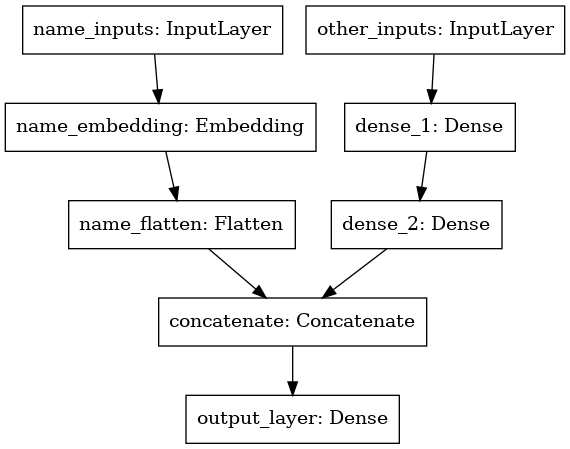

In [106]:
embedding_dim=64
#Traning on name features
name_inputs=tf.keras.Input(shape=(13,),name='name_inputs')
name_embedding=tf.keras.layers.Embedding(input_dim=vocab_length,
    output_dim=embedding_dim,
    input_length=max_seq_length,
    name='name_embedding'
)(name_inputs)
name_outputs=tf.keras.layers.Flatten(name='name_flatten')(name_embedding)


#Traiing on other features
other_inputs=tf.keras.Input(shape=(402,),name='other_inputs')

hidden=tf.keras.layers.Dense(64,activation='relu',name='dense_1')(other_inputs)
other_outputs=tf.keras.layers.Dense(64,activation='relu',name='dense_2')(hidden)
#concatenate outputs and make prediction
concat=tf.keras.layers.concatenate([name_outputs,other_outputs],name='concatenate')
outputs=tf.keras.layers.Dense(1,activation='sigmoid',name='output_layer')(concat)
#Constructing and plotting model
model=tf.keras.Model(inputs=[name_inputs,other_inputs],outputs=outputs)
tf.keras.utils.plot_model(model)


In [107]:
x_train_1=np.stack(x_train['Name'].to_numpy())
x_train_2=x_train.drop('Name',axis=1)

In [108]:
x_test_1=np.stack(x_test['Name'].to_numpy())
x_test_2=x_test.drop('Name',axis=1)

In [109]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ])

batch_size=64
epochs=100
history=model.fit(
    [x_train_1,x_train_2],
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()],
    verbose=2)


Epoch 1/100
23/23 - 2s - loss: 0.3936 - accuracy: 0.9550 - auc: 0.5677 - val_loss: 0.1675 - val_accuracy: 0.9834 - val_auc: 0.5817
Epoch 2/100
23/23 - 0s - loss: 0.0975 - accuracy: 0.9861 - auc: 0.6374 - val_loss: 0.0812 - val_accuracy: 0.9834 - val_auc: 0.6681
Epoch 3/100
23/23 - 0s - loss: 0.0651 - accuracy: 0.9861 - auc: 0.7908 - val_loss: 0.0772 - val_accuracy: 0.9834 - val_auc: 0.7594
Epoch 4/100
23/23 - 0s - loss: 0.0571 - accuracy: 0.9861 - auc: 0.9147 - val_loss: 0.0722 - val_accuracy: 0.9834 - val_auc: 0.8134
Epoch 5/100
23/23 - 0s - loss: 0.0512 - accuracy: 0.9861 - auc: 0.9644 - val_loss: 0.0680 - val_accuracy: 0.9834 - val_auc: 0.8829
Epoch 6/100
23/23 - 0s - loss: 0.0463 - accuracy: 0.9861 - auc: 0.9776 - val_loss: 0.0658 - val_accuracy: 0.9834 - val_auc: 0.8927
Epoch 7/100
23/23 - 0s - loss: 0.0425 - accuracy: 0.9861 - auc: 0.9845 - val_loss: 0.0643 - val_accuracy: 0.9834 - val_auc: 0.9005
Epoch 8/100
23/23 - 0s - loss: 0.0385 - accuracy: 0.9861 - auc: 0.9877 - val_loss: 

# Results

In [110]:
fig=px.line(
    history.history,
    y=['loss','val_loss'],
    labels={'x':'Epoch','y':'Loss'},
    title='Loss Over Time')
fig.show()